In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm.auto import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
from timm.scheduler import CosineLRScheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
import time

In [2]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 32, 
    'valid_bs': 32,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 8,
    'max_grad_norm' : 1000,
    'epochs_warmup' : 1.0
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [5]:
labels = expand_contact_id(pd.read_csv("../input/train_labels.csv"))

train_tracking = pd.read_csv("../input/train_player_tracking.csv")

train_helmets = pd.read_csv("../input/train_baseline_helmets.csv")

train_video_metadata = pd.read_csv("../input/train_video_metadata.csv")

In [6]:
# !mkdir -p ./work/frames

# import multiprocessing.dummy as mp
# from multiprocessing import Pool, cpu_count

# def do_print(video):
#     if 'Endzone2' not in video:
#         !ffmpeg -i ../input/train/{video} -r 25 -q:v 2 -f image2 ./work/frames/{video}_%04d.jpg -hide_banner -loglevel error

# if __name__=="__main__":
#     num_cpu = cpu_count()
#     p=mp.Pool(num_cpu)
#     p.map(do_print,tqdm(train_helmets.video.unique())) # range(0,1000) if you want to replicate your example
#     p.close()
#     p.join()

In [7]:
!mkdir -p ./work/frames

for video in tqdm(train_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i ../input/train/{video} -q:v 2 -f image2 ./work/frames/{video}_%04d.jpg -hide_banner -loglevel error

In [8]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

train, feature_cols = create_features(labels, train_tracking, use_cols=use_cols)

In [9]:
train_filtered = train.query('not distance>2').reset_index(drop=True)
train_filtered['frame'] = (train_filtered['step']/10*59.94+5*59.94).astype('int')+1
train_filtered.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38567,0,41.90,20.08,0.54,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,58168_003392,2020-09-11T03:01:48.100Z,0,37084,G,0,41.90,20.08,0.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,58168_003392,2020-09-11T03:01:48.100Z,0,37211,46445,0,39.59,17.07,0.53,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,58168_003392,2020-09-11T03:01:48.100Z,0,37211,G,0,39.59,17.07,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,58168_003392,2020-09-11T03:01:48.100Z,0,38556,G,0,41.93,30.61,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300


In [10]:
train_filtered['contact'].value_counts()

0    596241
1     64312
Name: contact, dtype: int64

In [11]:
video2helmets = {}
train_helmets_new = train_helmets.set_index('video')
for video in tqdm(train_helmets.video.unique()):
    video2helmets[video] = train_helmets_new.loc[video].reset_index(drop=True)

  0%|          | 0/481 [00:00<?, ?it/s]

In [12]:
video2frames = {}

for game_play in tqdm(train_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'./work/frames/{video}*'))))

  0%|          | 0/240 [00:00<?, ?it/s]

In [13]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [14]:
class MyDataset(Dataset):
    def __init__(self, df, aug=train_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'./work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]
                    
                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)
        # img = np.array(imgs)
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

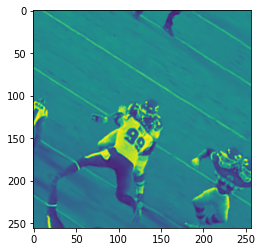

(torch.Size([26, 256, 256]),
 array([ 4.1900e+01,  2.0080e+01,  5.4000e-01,  6.0000e-02,  2.5269e+02,
         2.6231e+02,  9.2000e-01,  9.0000e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0000e+00], dtype=float32),
 0.0)

In [15]:
img, feature, label = MyDataset(train_filtered, train_aug, 'train')[1]
plt.imshow(img.permute(1,2,0)[:,:,9])
plt.show()
img.shape, feature, label

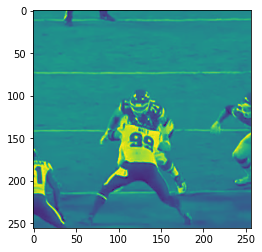

(torch.Size([26, 256, 256]),
 array([ 4.1900e+01,  2.0080e+01,  5.4000e-01,  6.0000e-02,  2.5269e+02,
         2.6231e+02,  9.2000e-01,  9.0000e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0000e+00], dtype=float32),
 0.0)

In [16]:
img, feature, label = MyDataset(train_filtered, valid_aug, 'valid')[1]
plt.imshow(img.permute(1,2,0)[:,:,9])
plt.show()
img.shape, feature, label

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=True, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [31]:
train_,valid_ = train_test_split(train_filtered,test_size=0.1, random_state=42,stratify = train_filtered['contact'])

In [32]:
# train_,valid_ = train_test_split(valid_,test_size=0.5, random_state=42)

In [33]:
train_['contact'].value_counts()

0    590278
1     63669
Name: contact, dtype: int64

In [34]:
valid_['contact'].value_counts()

0    5963
1     643
Name: contact, dtype: int64

In [35]:
train_.shape,valid_.shape

((653947, 26), (6606, 26))

In [36]:
train_set = MyDataset(train_, train_aug, 'train')
train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], shuffle=True, num_workers=12, pin_memory=True,drop_last=True)
valid_set = MyDataset(valid_, valid_aug, 'test')
valid_loader = DataLoader(valid_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=12, pin_memory=True)

In [37]:
model = Model()
model.to(device)
model.train()

Model(
  (backbone): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [38]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

In [39]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)
        
    total= len(loader_val)

    for ibatch,(img, feature, label) in tqdm(enumerate(loader_val),total = total):
        # img, feature, label = [x.to(device) for x in batch]
        img = img.to(device)
        feature = feature.to(device)
        n = label.size(0)
        label = label.to(device)

        with torch.no_grad():
            y_pred = model(img, feature)
        loss = criterion(y_pred.view(-1), label)

        n_sum += n
        loss_sum += n * loss.item()
        
        if pbar is not None:
            pbar.update(len(img))
        
        del loss, img, label
        gc.collect()

    loss_val = loss_sum / n_sum


    ret = {'loss': loss_val,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary
    gc.collect()
    return ret

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
nbatch = len(train_loader)
warmup = CFG['epochs_warmup'] * nbatch
nsteps = CFG['epochs'] * nbatch 

In [41]:
scheduler = CosineLRScheduler(optimizer,
              warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
              t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine

In [ ]:
time_val = 0.0
tb = time.time()
best_cv = 0
best_loss = 1e10
print('Epoch   loss        time')
for iepoch in range(CFG['epochs']):
    loss_sum = 0.0
    n_sum = 0
    
    total = len(train_loader)

    # Train
    for ibatch,(img, feature, label) in tqdm(enumerate(train_loader),total = total):
        img = img.to(device)
        feature = feature.to(device)
        n = label.size(0)
        label = label.to(device)
        

        optimizer.zero_grad()

        y_pred = model(img, feature).squeeze(-1)
        
        loss = criterion(y_pred, label)

        loss_train = loss.item()
        loss_sum += n * loss_train
        n_sum += n

        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG['max_grad_norm'])

        optimizer.step()

        scheduler.step(iepoch * nbatch + ibatch + 1)
        
    val = evaluate(model, valid_loader)
    time_val += val['time']
    loss_train = loss_sum / n_sum
    dt = (time.time() - tb) / 60
    print('Epoch %d %.4f %.4f %.2f min' %
          (iepoch + 1, loss_train, val['loss'],dt))
    if val['loss'] < best_loss:
        best_loss = val['loss']
        # Save model
        ofilename = 'model_pretrain_best_loss.pytorch'
        torch.save(model.state_dict(), ofilename)
        print(ofilename, 'written')
    del val
    gc.collect()

dt = time.time() - tb
print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))
gc.collect()

Epoch   loss          score   lr


  0%|          | 0/20435 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch 1 0.6364 0.5680 2.48 min
